In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, Multiply, Conv2DTranspose, Subtract, Add, Lambda, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from tensorflow.keras.utils import Sequence



In [2]:
def encoder_block(x, num_filters):
    c1 = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(num_filters,3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    return p1, c1

def decoder_block(x, skip, num_filters):
    u7 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u7 = Concatenate()([u7, skip])
    c7 = Conv2D(num_filters, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(num_filters, 3, activation='relu', padding='same')(c7)
    return c7

def residual_guided_fusion(rgb_decoder_out, depth_decoder_out, y_n, num_classes):
    # RGB PATH
    # generate RGB predicted mask y_hat_n through a 1 × 1 convolutional layer
    y_hat_n = Conv2D(num_classes, kernel_size=(1, 1), padding='same', name='y_hat_n', activation='softmax')(rgb_decoder_out)
    y_res = Subtract()([y_n, y_hat_n])

    # DEPTH PATH
    # we subtract the RGB feature maps with depth feature maps by element-wise subtraction to get the difference between them. 
    difference_maps = Subtract()([depth_decoder_out, rgb_decoder_out])
    # The channel of the different features is adjusted to the number of classes through a 1 × 1 convolution.
    depth_conv = Conv2D(num_classes, kernel_size=(1, 1), padding='same', activation='relu')(difference_maps)
    skip = depth_conv

    # Then a residual unit with a 3 × 3convolution is used to generate the predicted residual mask y_hat_nres
    depth_conv = Conv2D(num_classes, kernel_size=(3, 3), padding='same', activation='relu')(depth_conv)
    y_hat_res = Add()([depth_conv, skip])

    # The channel of y_hat_res is adjusted to that of the RGB feature maps by a 1 ×1 convolution and result is fused with the RGB feature maps through an element-wise multiplication
    channels_rgb = rgb_decoder_out.shape[-1]
    y_hat_res_conv = Conv2D(channels_rgb, kernel_size=(1, 1), padding='same', activation='relu')(y_hat_res)

    # After that, the adjusted result is fused with the RGB feature maps through an element-wise multiplication.
    combined_path = Multiply()([y_hat_res_conv, rgb_decoder_out])

    stacked = Concatenate()([combined_path, rgb_decoder_out, y_hat_res_conv])

    residual_differences = Subtract(name='residual_differences')([y_res, y_hat_res])

    return Conv2D(num_classes, kernel_size=(1, 1), padding='same', name='main_segmentation_out', activation='softmax')(stacked), y_hat_n, residual_differences


def unet(input_shape=(128, 256, 3), num_classes=20):
    inputs = Input(shape=input_shape)

    # Split the combined input tensor into RGB and depth
    inputs_rgb = Lambda(lambda x: x[..., :3])(inputs)
    inputs_depth = Lambda(lambda x: x[..., 3:4])(inputs)
    one_hot_y_input = Lambda(lambda x: x[..., 4:])(inputs)


    rgb_enc1, rgb_enc1_skip = encoder_block(inputs_rgb, 32) # (64,128,32)
    rgb_enc2, rgb_enc2_skip = encoder_block(rgb_enc1, 64) # (32,64,64)
    rgb_enc3, rgb_enc3_skip = encoder_block(rgb_enc2, 128) # (16,32,128)

    depth_enc1, depth_enc1_skip = encoder_block(inputs_depth, 32) # (64,128,32)
    depth_enc2, depth_enc2_skip = encoder_block(depth_enc1, 64) # (32,64,64)
    depth_enc3, depth_enc3_skip = encoder_block(depth_enc2, 128) # (16,32,128)

    # Bottleneck
    c5 = Conv2D(256, 3, activation='relu', padding='same')(rgb_enc3) # (16,32,256)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5) # (16,32,256)

    c6 = Conv2D(256, 3, activation='relu', padding='same')(depth_enc3) # (16,32,256)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6) # (16,32,256)

    # # Decoder

    depth_dec3 = decoder_block(c6, depth_enc3_skip, 128) # (16,32,128)
    depth_dec2 = decoder_block(depth_dec3, depth_enc2_skip, 64) # (32,64,64)
    depth_dec1 = decoder_block(depth_dec2, depth_enc1_skip, 32) # (64,128,32)

    rgb_dec3 = decoder_block(c5, rgb_enc3_skip, 128) # (16,32,128)
    # rgb_dec2 = decoder_block(rgb_dec3, rgb_enc2_skip, 64) # (32,64,64)
    # rgb_dec1 = decoder_block(rgb_dec2, rgb_enc1_skip, 32) # (64,128,32)

    rgb_dec2 = decoder_block(Add()([rgb_dec3, depth_dec3]), rgb_enc2_skip, 64) # (32,64,64)
    rgb_dec1 = decoder_block(Add()([rgb_dec2, depth_dec2]), rgb_enc1_skip, 32) # (64,128,32)

    main_output, y_hat_n, residual_differences = residual_guided_fusion(rgb_dec1,depth_dec1,one_hot_y_input,num_classes)

    model = Model(inputs=inputs, outputs=[main_output, y_hat_n])
    return model

In [3]:
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot for segmentation mask accuracy
    axes[0, 0].plot(history.history['segmentation_mask_accuracy'], label='Train Accuracy', marker='o')
    axes[0, 0].plot(history.history['val_segmentation_mask_accuracy'], label='Val Accuracy', marker='o')
    axes[0, 0].set_title('Segmentation Mask Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(loc='lower right')

    # Plot for species classification accuracy
    axes[0, 1].plot(history.history['species_accuracy'], label='Train Accuracy', marker='o')
    axes[0, 1].plot(history.history['val_species_accuracy'], label='Val Accuracy', marker='o')
    axes[0, 1].set_title('Species Classification Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend(loc='lower right')

    # Plot for segmentation mask loss
    axes[1, 0].plot(history.history['segmentation_mask_loss'], label='Train Loss', marker='x')
    axes[1, 0].plot(history.history['val_segmentation_mask_loss'], label='Val Loss', marker='x')
    axes[1, 0].set_title('Segmentation Mask Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend(loc='upper right')

    # Plot for species classification loss
    axes[1, 1].plot(history.history['species_loss'], label='Train Loss', marker='x')
    axes[1, 1].plot(history.history['val_species_loss'], label='Val Loss', marker='x')
    axes[1, 1].set_title('Species Classification Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [4]:
# Paths to the dataset
rgb_dir = './train/image'
label_dir = './train/label'
depth_dir = './train/depth'

# Parameters
rgb_shape = (128, 256, 3)
depth_shape = (128, 256, 1)
input_shape = (128, 256, 24)
label_shape = (128, 256)
num_classes = 20
batch_size = 16


class NPYDataGenerator(Sequence):
    def __init__(self, rgb_dir, label_dir, depth_dir, batch_size=8, image_size=(128, 256), num_classes=20, shuffle=True):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.depth_dir = depth_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.file_indices = sorted([int(f.split('.')[0]) for f in os.listdir(rgb_dir)])
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.file_indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_indices)

    def __data_generation(self, batch_indices):
        # Initialize empty arrays for RGB, depth, and labels
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        depth = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Depth with 1 channel
        y = np.empty((self.batch_size, *self.image_size, 1), dtype=np.int32) # One hot encoded y with 19 channels one for each segmentation class

        for i, idx in enumerate(batch_indices):
            rgb_path = os.path.join(self.rgb_dir, f"{idx}.npy")
            label_path = os.path.join(self.label_dir, f"{idx}.npy")
            depth_path = os.path.join(self.depth_dir, f"{idx}.npy")
            
            # Load and normalize RGB image
            X[i] = np.load(rgb_path).astype(np.float32) / 255.0      
                  
            # Load and normalize depth map
            depth[i] = np.load(depth_path).astype(np.float32) / 255.0  # Assuming depth is in [0, 255] range
            
            # Load label and add 1 to shift labels from -1 (background) to 0 (background) and 1-19 for classes
            y[i] = np.load(label_path).astype(np.int32).reshape((*self.image_size, 1)) + 1
        
        y_one_hot = to_categorical(y, num_classes=num_classes)
        combined_input = np.concatenate([X, depth, y_one_hot], axis=-1)
        y_zeros = np.zeros_like(y_one_hot)        

        return combined_input, {'main_segmentation_out': y_one_hot, 'y_hat_n': y_one_hot}

# Initialize the data generator
train_generator = NPYDataGenerator(rgb_dir, label_dir, depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

# Paths to the validation dataset
val_rgb_dir = './val/image'
val_label_dir = './val/label'
val_depth_dir = './val/depth'

# Initialize the data generator for validation
val_generator = NPYDataGenerator(val_rgb_dir, val_label_dir, val_depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

In [6]:
# Define the model
unet_model = unet(input_shape, num_classes)

unet_model.compile(
    optimizer=Adam(),
    loss={'main_segmentation_out': CategoricalCrossentropy(from_logits=False), 
          'y_hat_n': CategoricalCrossentropy(from_logits=False),
          },
    metrics={'main_segmentation_out': 'accuracy', 'y_hat_n': 'accuracy'}
)

unet_history = unet_model.fit(train_generator,validation_data=val_generator ,epochs=10)


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 793s 5s/step - loss: 5.0170 - main_segmentation_out_accuracy: 0.2703 - y_hat_n_accuracy: 0.3288 - val_loss: 3.6167 - val_main_segmentation_out_accuracy: 0.3779 - val_y_hat_n_accuracy: 0.3997
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 712s 5s/step - loss: 3.2058 - main_segmentation_out_accuracy: 0.4718 - y_hat_n_accuracy: 0.4718 - val_loss: 2.6557 - val_main_segmentation_out_accuracy: 0.5273 - val_y_hat_n_accuracy: 0.5383
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 716s 5s/step - loss: 2.6518 - main_segmentation_out_accuracy: 0.5351 - y_hat_n_accuracy: 0.5378 - val_loss: 2.5707 - val_main_segmentation_out_accuracy: 0.5479 - val_y_hat_n_accuracy: 0.5352
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 705s 5s/step - loss: 2.4604 - main_segmentation_out_accuracy: 0.5742 - y_hat_n_accuracy: 0.5713 - val_loss: 2.2597 - val_main_segmentation_out_accuracy: 0.6277 - val_y_hat_n_accuracy: 0.6217
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 708s 5s/step - loss: 2.1749 - main_s

In [9]:
unet_model.save_weights("./RGF_weights.weights.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


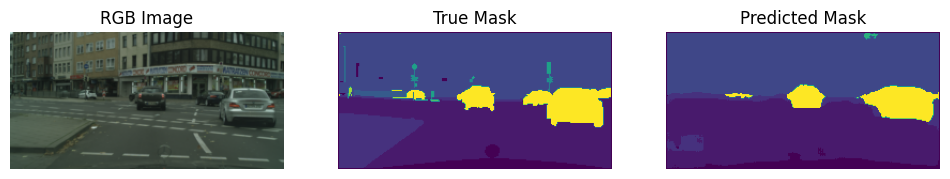

In [10]:
# Paths to the test dataset
test_rgb_dir = './test/image'
test_label_dir = './test/label'  # Optional, only if you want to evaluate against ground truth
test_depth_dir = './test/depth'

# Initialize the test data generator
test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False  # Shuffling disabled for consistency during testing
)

# Load one batch from the validation generator
val_images, val_labels = test_generator[0]

# Select the first image in the batch
sample_image = val_images[0]  # This includes RGB, depth, and one-hot label channels
true_label = val_labels['main_segmentation_out'][0]  # Ground truth segmentation mask for the main output

# Predict using the model
predictions = unet_model.predict(np.expand_dims(sample_image, axis=0))

# Extract predicted segmentation mask
predicted_mask = np.argmax(predictions[0][0], axis=-1)  # main_segmentation_out is the first output in the list
true_mask = np.argmax(true_label, axis=-1)

# Plot the RGB image, true mask, and predicted mask
plt.figure(figsize=(12, 4))

# Display RGB image
plt.subplot(1, 3, 1)
plt.imshow(sample_image[:, :, :3]*255)  # Only take RGB channels
plt.title("RGB Image")
plt.axis('off')

# Display ground truth segmentation mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("True Mask")
plt.axis('off')

# Display predicted segmentation mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

 

In [14]:
import matplotlib.pyplot as plt

def plotHistory(history, name):
    acc = history.history['main_segmentation_out_accuracy']
    val_acc = history.history['val_main_segmentation_out_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'{name}: accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{name}: loss')
    plt.legend()

    plt.show()

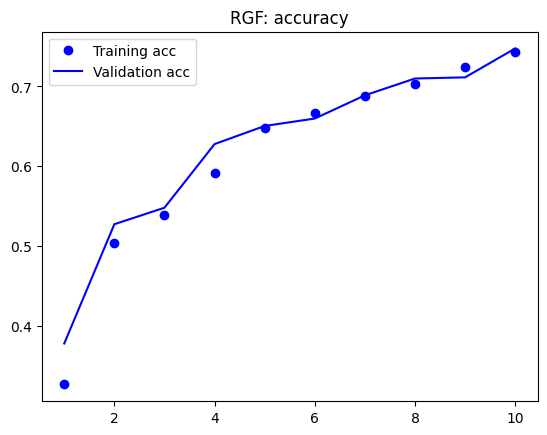

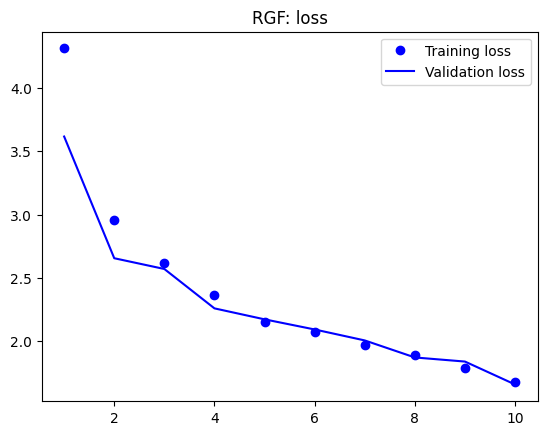

In [15]:
plotHistory(unet_history, "RGF")

In [68]:
print(np.sum(predictions[0][0], axis=2).shape)
np.sum(predictions[0][0], axis=2)

(128, 256)


array([[1.        , 1.        , 0.99999994, ..., 1.        , 1.        ,
        1.        ],
       [1.0000001 , 0.99999994, 0.99999994, ..., 1.        , 1.        ,
        1.        ],
       [0.99999994, 0.9999999 , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 0.99999994,
        1.0000001 ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.0000001 , 1.0000001 , 1.        , ..., 1.0000001 , 1.0000001 ,
        1.0000001 ]], dtype=float32)

In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8240610819926028754
 xla_global_id: -1]